## Import Packages

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Ideas for Lane Detection Pipeline

In [ ]:
import pandas as pd
import math
import os

# Helper Functions

In [153]:
def show_image(image, cmap="gray", text=""):
        plt.imshow(image, cmap=cmap)
        plt.text(0,image.shape[0]*1.25,text)
        plt.show()
        
def binary_threshold_channel(channel, thresh=(90,255)):
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary

def compute_radius_of_curvature(fit, y):
    A,B,C = fit
    return ((1 + (2*A*y + B)**2)**1.5) / np.absolute(2*A)

# Apply distortion correction to raw images.

In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
import glob

In [ ]:
def calibrate(path='./camera_cal/calibration*.jpg'):
    image_paths = glob.glob(path)
    imagepoints = []
    objpoints = []

    nx = 9
    ny = 6

    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Convert to grayscale
    for image_path in image_paths:
        # print("processing {}".format(image_path))
        image = read_image(image_path)
        img = image.copy()

        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        show_image(image, text="Gray Scale Image")

        # Find the chessboard corners
        corner_ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if corner_ret == True:
        # Draw and display the corners
            imagepoints.append(corners)
            objpoints.append(objp)
            cv2.drawChessboardCorners(image, (nx, ny), corners, corner_ret)

            show_image(img, text="Distored Image")

            # * Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imagepoints, img.shape[1::-1], None, None)

            undistorted = cv2.undistort(img, mtx, dist, None, mtx)

            show_image(undistorted, text="Undistorted")

            src = np.float32([corners[0],corners[8],corners[35],corners[27]])

            w, h = img.shape[1::-1]

            top = 0.1; bottom = 0.55; left = 0.1; right = 0.9

            dst = np.float32([[w*left, h*top],[w*right, h*top],[w*right, h*bottom],[w*left, h*bottom]])

            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            M = cv2.getPerspectiveTransform(src, dst)

            # e) use cv2.warpPerspective() to warp your image to a top-down view
            warped = cv2.warpPerspective(undistorted, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
            show_image(warped, text="Perspective Warped image")

    calibration_values = {
        'imgpoints': imagepoints,
        'objpoints': objpoints,
        'mtx_distortion_correction': mtx,
        'distortion_coefficient': dist
    }
    pickle.dump(calibration_values, open( "calibration_values.p", "wb" ) )

In [221]:
from line import Line
class Pipeline:        
    def __init__(self):
        self.calibration_values = pickle.load(open('calibration_values.p','rb'))
        self.mtx = self.calibration_values['mtx_distortion_correction']
        self.dist_coeff = self.calibration_values['distortion_coefficient']
        self.perspective_transform_matrix = None
        self.original_image = None
        self.image = None
        self.left_lane = Line()
        self.right_lane = Line()
        self.result_image = None
        self.image_hls = None
        self.empty_channel = None
    
    def convert_to_grayscale(self, image):
        return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    def read_image(self, image):
        if type(image) == str:
            self.original_image = cv2.imread(os.path.realpath(image))
            self.convert_bgr_2_rgb()
        else:
            self.original_image = image
        self.image = self.original_image.copy()
        self.empty_channel = np.zeros_like(self.original_image[:,:,0])
        
    def convert_bgr_2_rgb(self):
        self.original_image = cv2.cvtColor(self.original_image, cv2.COLOR_BGR2RGB)
        
    def convert_rgb_2_hls(self):
        self.image_hls = cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)
    
    def show_image(self, text="", cmap="gray"):
        image = self.image
        show_image(image, text=text, cmap=cmap)
    
    def undistort(self):
        self.image = cv2.undistort(self.image, self.mtx, self.dist_coeff, None, self.mtx)
        
    def abs_sobel_thresh(self, orient='x', sobel_kernel=3, thresh=(0, 255)):    
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = self.convert_to_grayscale(self.image)

        # 2) Take the derivative in x or y given orient = 'x' or 'y'
        if orient == "x":
            sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        elif orient == "y":
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

        # 3) Take the absolute value of the derivative or gradient
        abs_sobel = np.absolute(sobel)

        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

        # 5) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

        # 6) Return this mask as your binary_output image
        return sxbinary

    def mag_thresh(self, sobel_kernel=3, mag_thresh=(0, 255)):
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = self.convert_to_grayscale(self.image)

        # 2) Take the derivative in x or y given orient = 'x' or 'y'

        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        sobel = np.sqrt(np.multiply(sobelx,sobelx) + np.multiply(sobely,sobely))

        # 3) Take the absolute value of the derivative or gradient
        abs_sobel = np.absolute(sobel)

        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

        # 5) Create a mask of 1's where the scaled gradient magnitude 
                # is > thresh_min and < thresh_max
        binary = np.zeros_like(scaled_sobel)
        binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

        # 6) Return this mask as your binary_output image
        return binary

    def dir_thresh(self, sobel_kernel=3, thresh=(0, np.pi/2)):
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = self.convert_to_grayscale(self.image)

        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

        # 3) Take the absolute value of the x and y gradients
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)

        # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        abs_grad = np.arctan2(abs_sobely, abs_sobelx)

        # 5) Create a binary mask where direction thresholds are met
        binary = np.zeros_like(abs_grad)
        binary[(abs_grad >= thresh[0]) & (abs_grad <= thresh[1])] = 1    
        return binary
    
    def color_gradient_threshold_transform(self):
        # Choose a Sobel kernel size
        
        # Choose a larger odd number to smooth gradient measurements
        ksize = 3 
        
        # Apply each of the thresholding functions
        gradx = self.abs_sobel_thresh(orient='x', sobel_kernel=ksize, thresh=(20, 100))
        grady = self.abs_sobel_thresh(orient='y', sobel_kernel=ksize, thresh=(20, 100))
        mag_binary = self.mag_thresh(sobel_kernel=ksize, mag_thresh=(20, 100))
        dir_binary = self.dir_thresh(sobel_kernel=ksize, thresh=(0.7, 1.3))
        
        self.convert_rgb_2_hls()
        H = self.image_hls[:,:,0]
        L = self.image_hls[:,:,1]
        S = self.image_hls[:,:,2]

        R = self.image[:,:,0]
        G = self.image[:,:,1]
        B = self.image[:,:,2]
        
        # Binary Threshold in Color Spaces
        H_binary = binary_threshold_channel(H)
        L_binary = binary_threshold_channel(L)
        S_binary = binary_threshold_channel(S)

        R_binary = binary_threshold_channel(R)
        G_binary = binary_threshold_channel(G)
        B_binary = binary_threshold_channel(B)
        
        combined = ((gradx & grady & R_binary))
        
        color_binary = np.dstack((self.empty_channel, combined, S_binary)) * 255
        
        thresholded_image = (combined | S_binary)
        
        self.image = thresholded_image
        
    def create_mask_corners(self):
        xsize = self.image.shape[1]
        ysize = self.image.shape[0] *0.99

        left_bottom = [xsize*0.18, ysize]
        right_bottom = [xsize*0.85, ysize]

        left_top = [xsize*0.49, ysize*0.6]
        right_top = [xsize*0.505, ysize*0.6]

        x = [left_bottom[0], right_bottom[0], right_top[0], left_top[0], left_bottom[0]]
        y = [left_bottom[1], right_bottom[1], right_top[1], left_top[1],  left_bottom[1]]
        
        self.mask_corners = np.array([i for i in zip(x,y)])
        
    def draw_mask(self):
        plt.imshow(self.image,cmap="gray")
        x = self.mask_corners.T[0]
        y = self.mask_corners.T[1]
        plt.plot(x, y, 'r', lw=1)
        plt.show()
        
    def perspective_transform(self):
        image = self.image
        corners = self.mask_corners
        
        w, h = image.shape[1::-1]
        top = -3; bottom = 1; left = 0.3; right = 0.7

        src = np.float32([corners[3],corners[2],corners[1],corners[0]])
        dst = np.float32([[w*left, h*top],[w*right, h*top],[w*right, h*bottom],[w*left, h*bottom]])

        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)

        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(image, M, image.shape[1::-1], flags=cv2.INTER_LINEAR)
        self.image = warped
        self.perspective_transform_matrix = M

    def detect_lane_lines(self):
        # * Detect lane pixels and fit to find the lane boundary.
        binary_warped = self.image
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((self.empty_channel, self.empty_channel, self.empty_channel))*255

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9

        im_h, im_w = binary_warped.shape

        # Set height of windows
        window_height = np.int(im_h/nwindows)

        binary_warped.nonzero()

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = im_h - (window+1)*window_height
            win_y_high = im_h - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
#             cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
#             (0,255,0), 3) 
#             cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
#             (0,255,0), 3) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                non_zero_x_indices_within_window = nonzerox[good_left_inds]
                mean_within_window = np.int(np.mean(non_zero_x_indices_within_window))
                leftx_current = mean_within_window

            if len(good_right_inds) > minpix:     
                non_zero_x_indices_within_window = nonzerox[good_right_inds]
                mean_within_window = np.int(np.mean(non_zero_x_indices_within_window))
                rightx_current = mean_within_window

        # Flatten/Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        self.left_lane.current_fit = left_fit
        self.right_lane.current_fit = right_fit
        
        self.left_lane.allx = left_fitx
        self.left_lane.ally = ploty

        self.right_lane.allx = right_fitx
        self.right_lane.ally = ploty
        
        self.result_image = out_img
    
    def detect_lane_lines_with_prior(self):
        binary_warped = self.image
        left_fit = self.left_lane.current_fit
        right_fit = self.right_lane.current_fit

        # Finding lane lines in following frames
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100

        previous_frame_lane_x_coords = (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2])
        left_lane_inds = (
            (nonzerox > (previous_frame_lane_x_coords - margin)) & 
            (nonzerox < (previous_frame_lane_x_coords + margin))
        ) 

        previous_frame_lane_x_coords = (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2])
        right_lane_inds = (
            (nonzerox > (previous_frame_lane_x_coords - margin)) & 
            (nonzerox < (previous_frame_lane_x_coords + margin))
        )

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img = np.dstack((self.empty_channel, self.empty_channel, self.empty_channel))
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        self.left_lane.current_fit = left_fit
        self.right_lane.current_fit = right_fit

        self.left_lane.allx = left_fitx
        self.left_lane.ally = ploty

        self.right_lane.allx = right_fitx
        self.right_lane.ally = ploty
        
    def draw_window_on_lanes(self):
        binary_warped = self.image
        left_fit = self.left_lane.current_fit
        right_fit = self.right_lane.current_fit
        
        left_fitx = self.left_lane.allx
        right_fitx = self.right_lane.allx
        ploty = self.left_lane.ally
        
        margin=50
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])

        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])

        left_line_pts = np.hstack((left_line_window1, left_line_window2))

        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
        window_img = np.zeros_like(self.result_image)
        
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0,255))
        self.result_image = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    def plot_detect_lanes_with_polygon_window(self):
        # Draw the lane onto the warped blank image
        plt.imshow(self.result_image)
        plt.plot(self.left_lane.allx, self.left_lane.ally, color='yellow')
        plt.plot(self.right_lane.allx, self.right_lane.ally, color='yellow')
        plt.xlim(0, self.image.shape[1])
        plt.ylim(self.image.shape[0], 0)
        plt.show()
        
    def plot_detected_lanes(self):
        plt.xlim(0, self.image.shape[1])
        plt.ylim(self.image.shape[0], 0)
        plt.imshow(self.result_image)
        plt.plot(self.left_lane.allx, self.left_lane.ally, color='yellow')
        plt.plot(self.right_lane.allx, self.right_lane.ally, color='yellow')
        plt.show()
        
    # * Warp the detected lane boundaries back onto the original image.
    def warp_perspective_to_original(self):
        binary_warped = self.image
        left_fitx = self.left_lane.allx
        right_fitx = self.right_lane.allx
        plot_y = self.left_lane.ally

        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0));
        
        color_warp = cv2.addWeighted(self.result_image, 1, color_warp, 1, 0)

        Minv = np.linalg.inv(self.perspective_transform_matrix)

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        image = self.original_image
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
        self.image = result
        self.result_image = result
        
    def compute_radius_of_curvature_for_fit(self):
        self.left_lane.radius_of_curvature = compute_radius_of_curvature(self.left_lane.current_fit, np.max(self.left_lane.ally))
        self.right_lane.radius_of_curvature = compute_radius_of_curvature(self.right_lane.current_fit, np.max(self.right_lane.ally))
        print(self.left_lane.radius_of_curvature, self.right_lane.radius_of_curvature)
        # Example values: 1926.74 1908.48

    def compute_radius_of_curvature_for_fit_in_meters(self):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(self.left_lane.ally*ym_per_pix, self.left_lane.allx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(self.right_lane.ally*ym_per_pix, self.right_lane.allx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        self.left_lane.radius_of_curvature = compute_radius_of_curvature(left_fit_cr, np.max(self.left_lane.ally)*ym_per_pix)
        self.right_lane.radius_of_curvature = compute_radius_of_curvature(right_fit_cr, np.max(self.right_lane.ally)*ym_per_pix)

        # Now our radius of curvature is in meters
        print(self.left_lane.radius_of_curvature, self.right_lane.radius_of_curvature)
        # Example values: 632.1 m    626.2 m
    
    def find_lanes(self, image, show=True):
        self.read_image(image)

#         self.convert_bgr_2_rgb()
        # self.show_image(text="RGB")

        self.undistort()
        # self.show_image(text="Undistorted")

        self.color_gradient_threshold_transform()
        # self.show_image(text="Thresholded")

        self.create_mask_corners()
        # self.draw_mask()

        self.perspective_transform()
        # self.show_image(text="Perspective Warped image")
        
        self.detect_lane_lines()
#         self.draw_window_on_lanes()
        
#         self.plot_detected_lanes()
#         self.detect_lane_lines_with_prior()
#         self.plot_detect_lanes_with_polygon_window()
#         self.compute_radius_of_curvature_for_fit_in_meters()

        self.warp_perspective_to_original()
        
        if show:
            self.show_image()
            
        return self.result_image

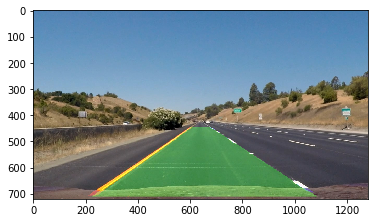

In [222]:
Pipeline().find_lanes('./test_images/straight_lines1.jpg');

In [186]:
# * Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# Single Image Test

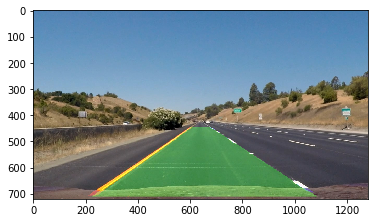

In [204]:
image_list = os.listdir('test_images')
image_path = image_list[0]
Pipeline().find_lanes("test_images/"+image_path)

# All Test Images

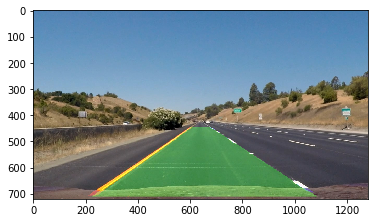

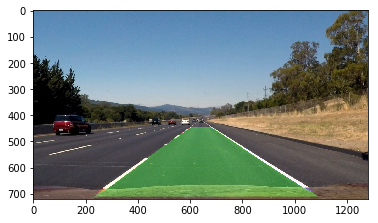

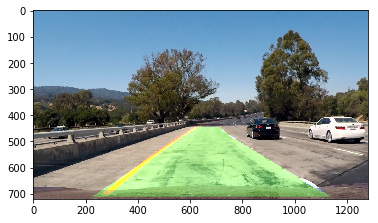

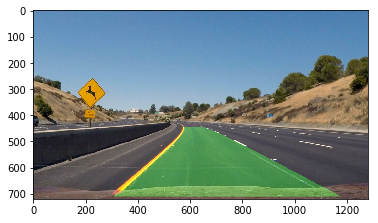

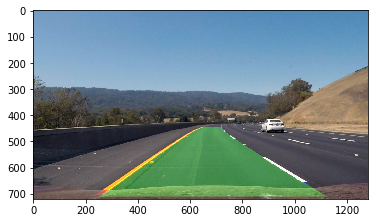

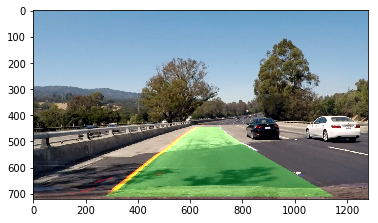

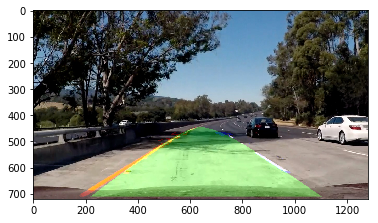

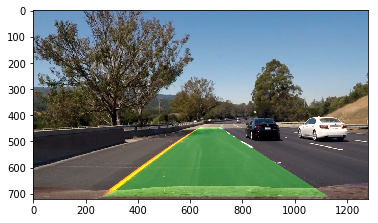

In [205]:
image_list = os.listdir("test_images/")
for i in range(0,len(image_list)):
    image_path = image_list[i]
    Pipeline().find_lanes("test_images/"+image_path)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [223]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = Pipeline().find_lanes(image, show=False)
    return result

# Let's try the one with the solid white lane on the right first ...

white_output = './output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(0,3)
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output_images/project_video.mp4
[MoviePy] Writing video ./output_images/project_video.mp4


 99%|█████████▊| 75/76 [00:30<00:00,  2.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video.mp4 

CPU times: user 38.9 s, sys: 3.5 s, total: 42.4 s
Wall time: 31.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [218]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(5,10)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4')
# clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))